In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('viridis')

regions = ['nsw', 'sa']
y_axis_var = 'net_load'

dfs = []
for region in regions:
    df = pd.read_csv(f'../data/{region}/merged.csv')
    df.datetime = df.datetime.astype('datetime64')
    df['region'] = region
    dt = df['datetime'].dt
    df['date'] = dt.date
    df['year'] = dt.year
    df['month'] = dt.month
    df['day'] = dt.day
    df['hour'] = dt.hour
    df['minute'] = dt.minute
    df['day_of_week'] = dt.weekday.astype('str') + '-' + dt.day_name().str[:3]
    df['isoyear'] = dt.isocalendar().year
    df['week'] = dt.isocalendar().week
    df['day_of_year'] = dt.day_of_year
    df['week_of_month'] = (dt.day - 1) // 7 # day of month - 1 (0-30) // 7 (0-6=0, 7-13=1, 14-20=2, 21-27=3, 28-x=4)
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,...,week,day_of_year,week_of_month,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
0,2018-03-06 10:00:00,8499.5,8332.145,434.3715,19.0,2.0,15.0,110.0,52.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-06 11:00:00,8457.0,8294.325,468.8860,19.4,1.0,14.0,140.0,49.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-06 12:00:00,8396.0,8248.405,483.1315,19.1,4.0,15.0,150.0,52.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-06 13:00:00,8341.5,8193.080,491.4175,19.4,4.0,14.0,140.0,55.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-06 14:00:00,8321.5,8185.100,487.9780,18.9,7.0,17.0,120.0,57.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


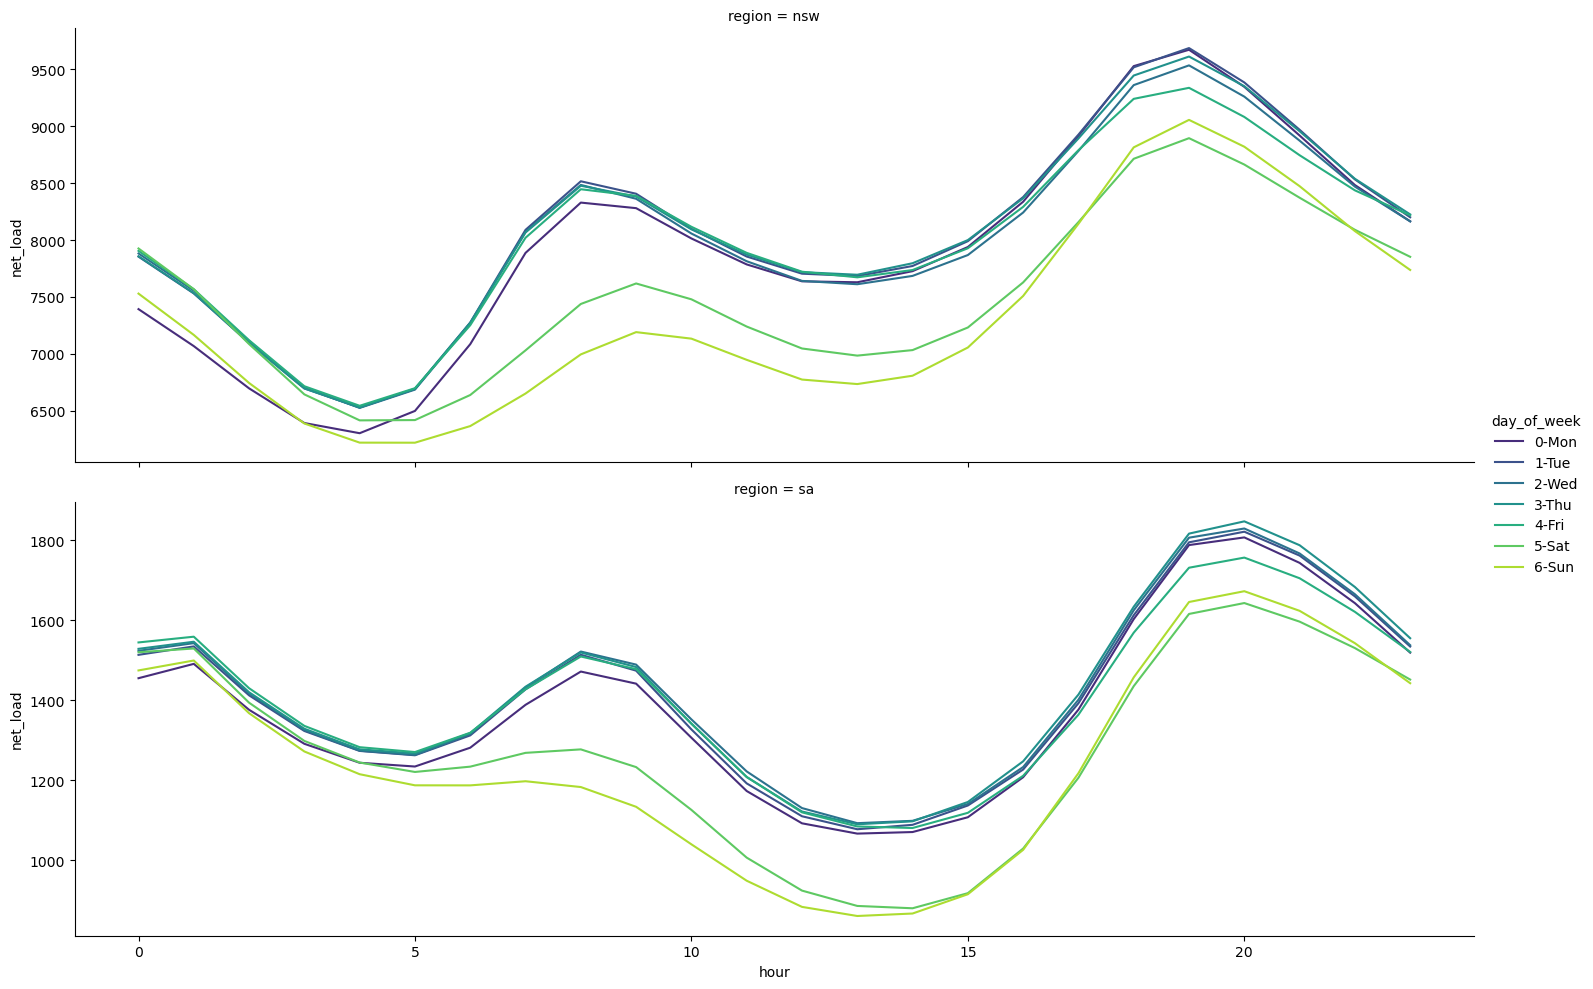

In [21]:
grouped_dow = df.groupby(['region', 'day_of_week', 'hour', 'minute'])[[y_axis_var]].mean()
g = sns.relplot(grouped_dow.reset_index(), x='hour', y=y_axis_var, kind='line', row='region', 
                hue='day_of_week', palette='viridis', facet_kws={'sharey':False}, aspect=3)
g.savefig('../plots/dow_net_load')

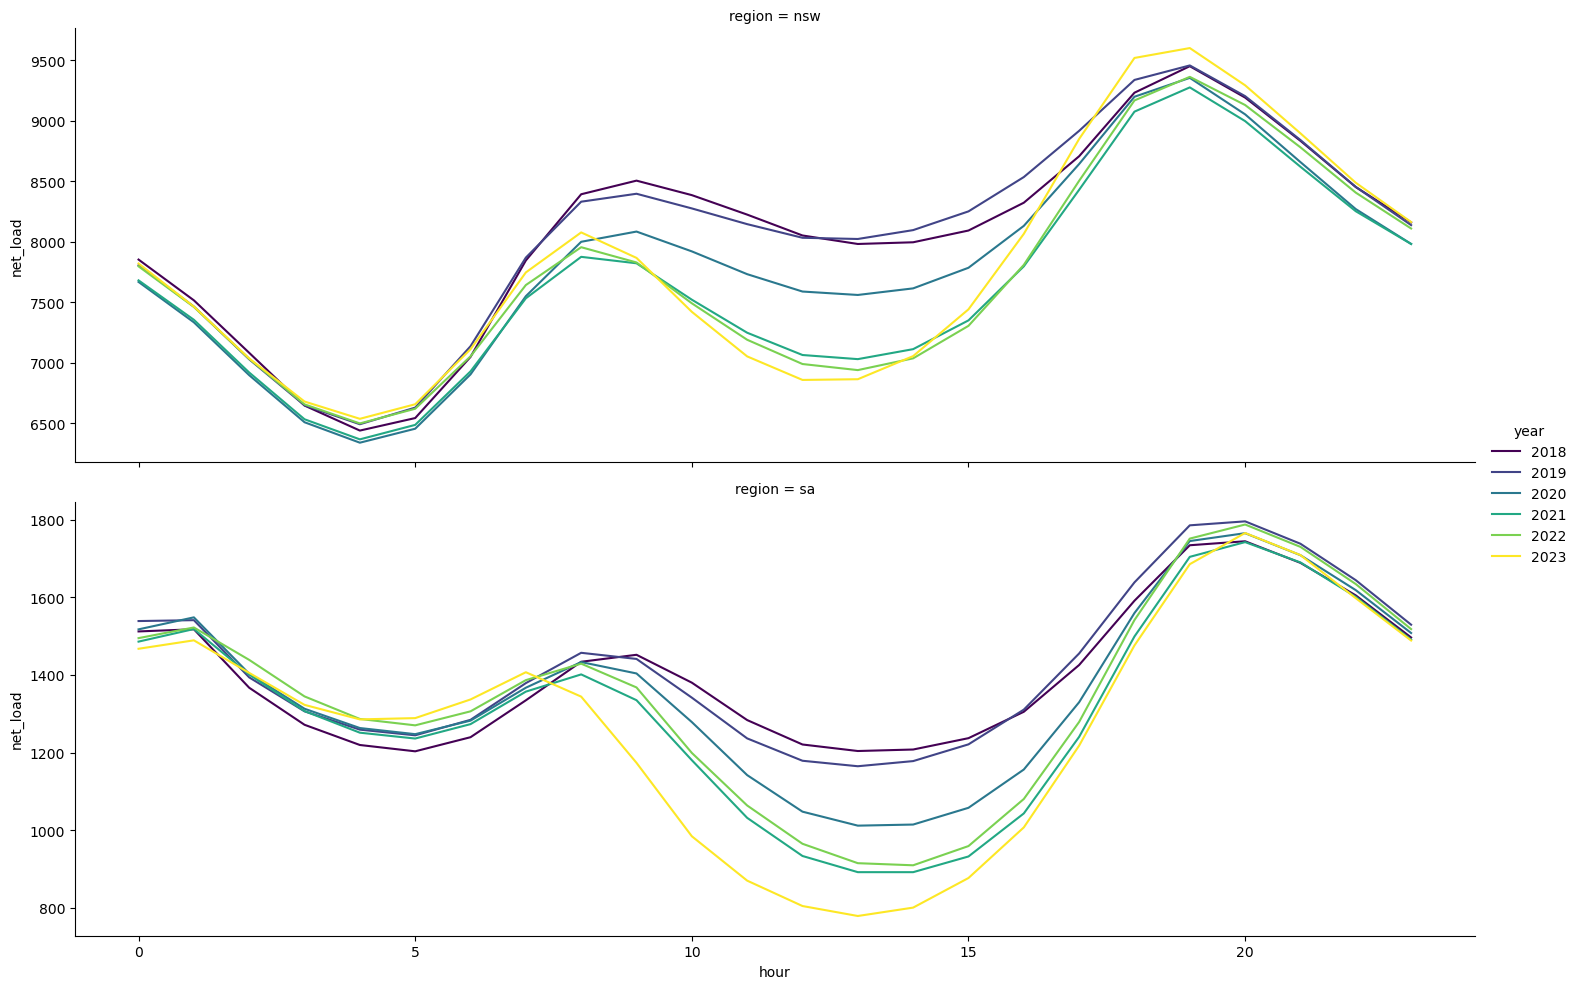

In [22]:
grouped_dow_year = df.groupby(['region', 'year', 'hour', 'minute'])[[y_axis_var]].mean()
g = sns.relplot(grouped_dow_year.reset_index(), x='hour', y=y_axis_var, kind='line', row='region', 
                hue='year', palette='viridis', facet_kws={'sharey':False}, aspect=3)
g.savefig('../plots/dow_net_load_years')

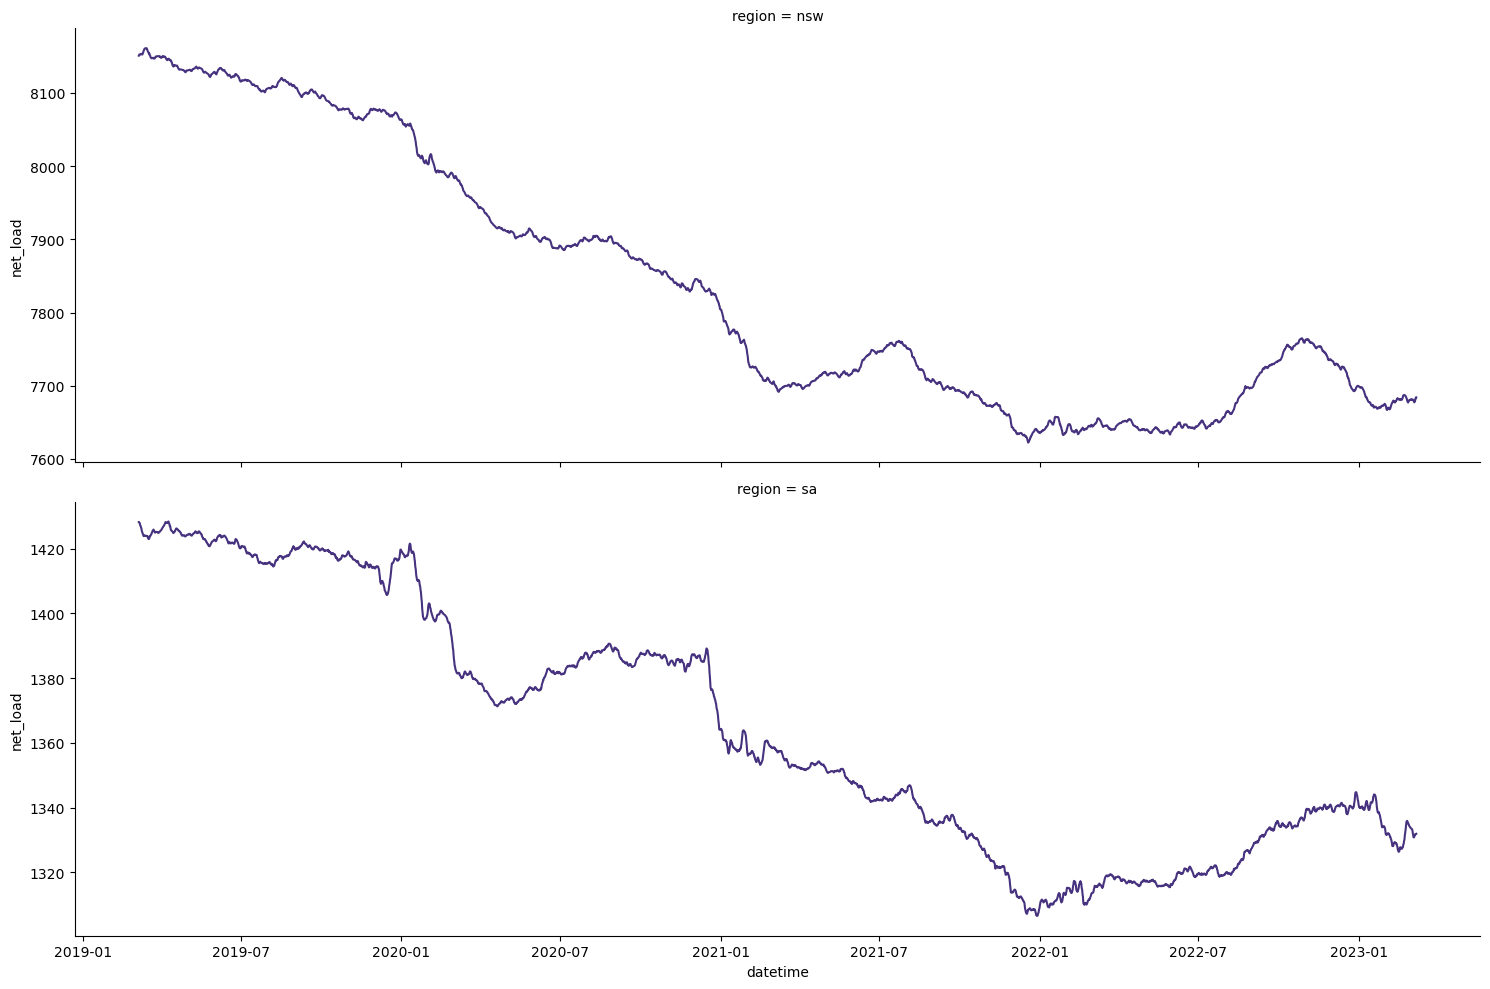

In [4]:
# 1 year moving average
region_pivot = df[['datetime', 'region', y_axis_var]].pivot(index='datetime', columns='region', values=y_axis_var)
moving = region_pivot.rolling(24*365).mean().dropna().reset_index().melt(id_vars='datetime', var_name='region', value_name=y_axis_var)
g = sns.relplot(moving.reset_index(), x='datetime', y=y_axis_var, row='region', kind='line', facet_kws={'sharey':False}, aspect=3)
g.savefig('../plots/mvng_avg_1yr.png')

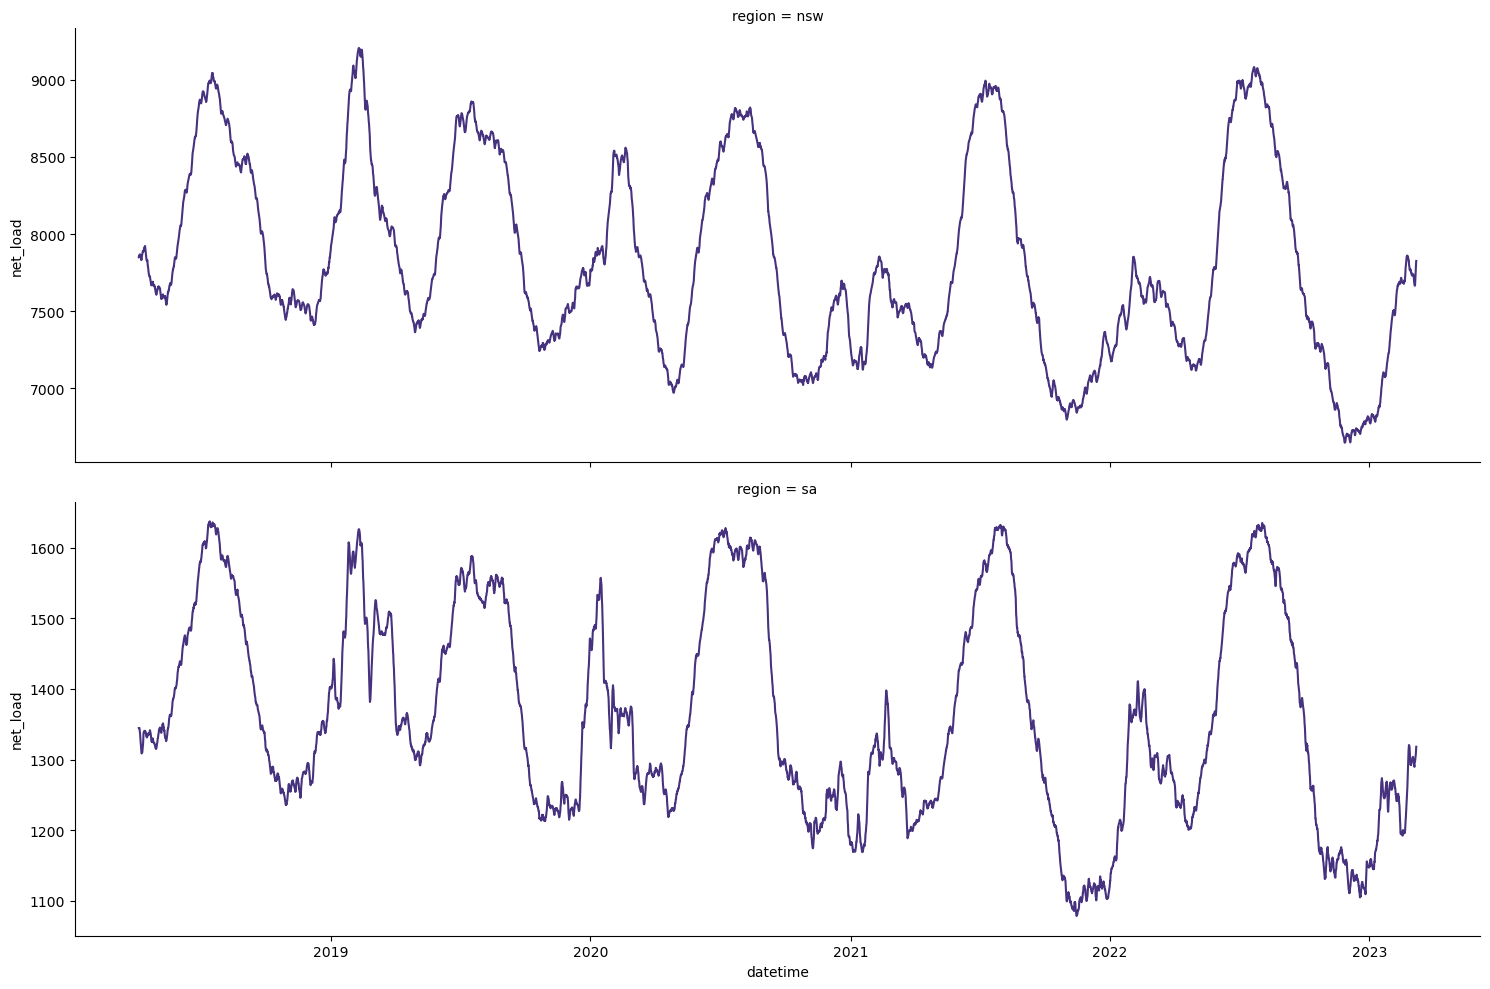

In [5]:
# 1 month moving average
region_pivot = df[['datetime', 'region', y_axis_var]].pivot(index='datetime', columns='region', values=y_axis_var)
moving = region_pivot.rolling(24*30).mean().dropna().reset_index().melt(id_vars='datetime', var_name='region', value_name=y_axis_var)
g = sns.relplot(moving.reset_index(), x='datetime', y=y_axis_var, row='region', kind='line', facet_kws={'sharey':False}, aspect=3)
g.savefig('../plots/mvng_avg_1month.png')

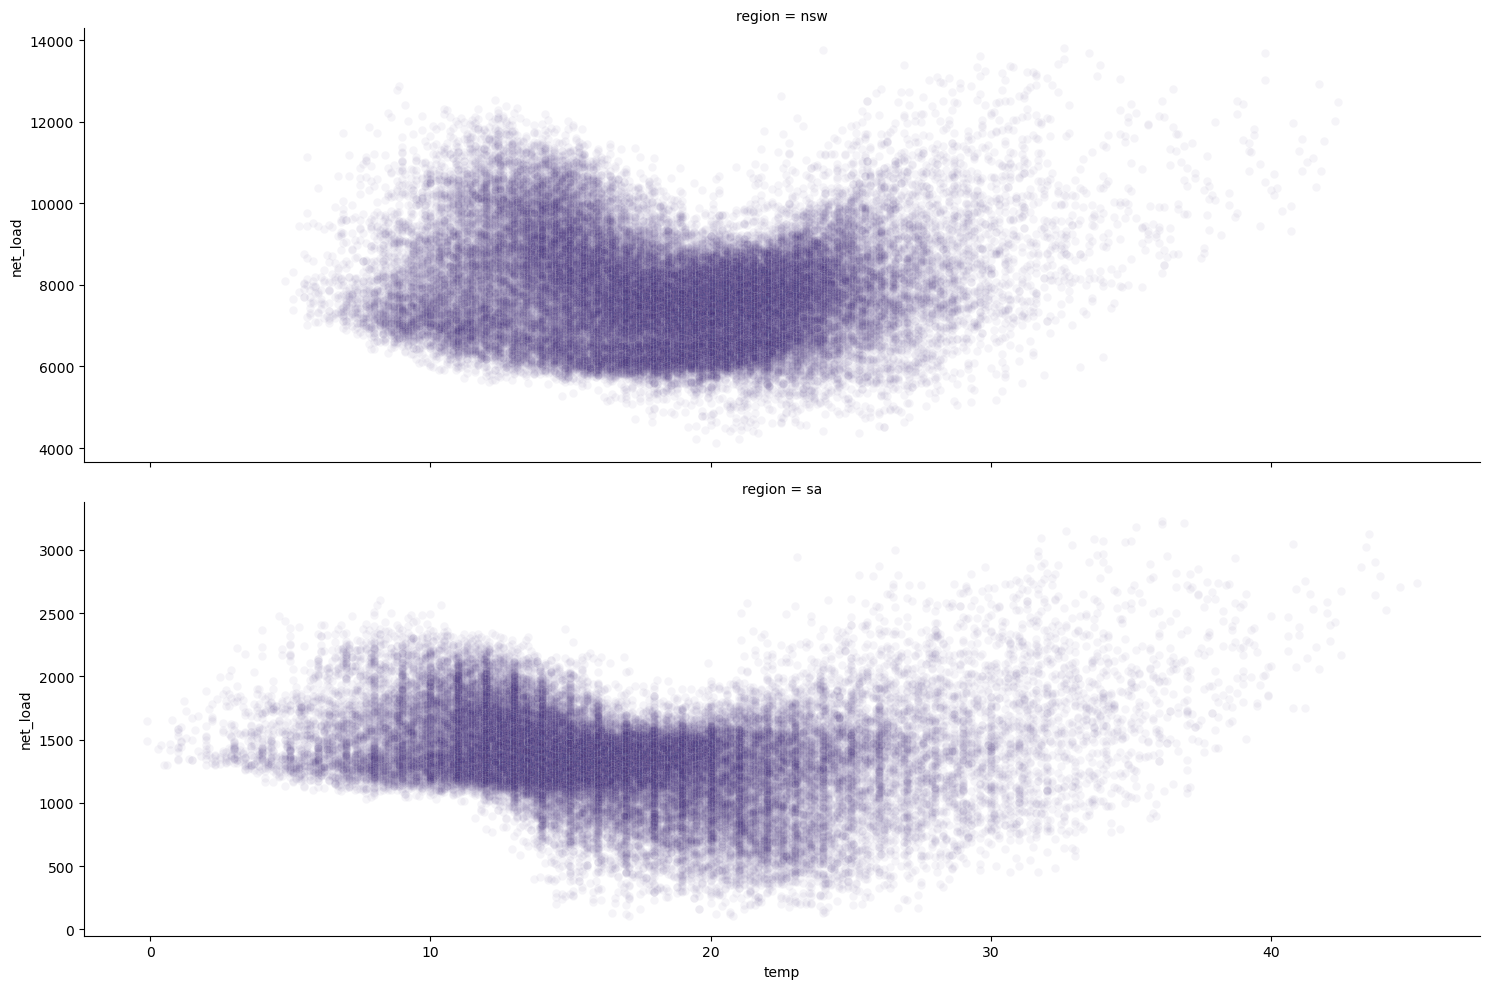

In [23]:
def scatter(value_vars, value_name, alpha=0.1, sharex=True, **kwargs):
    subdf = df.melt(id_vars=['datetime', 'region', y_axis_var], value_vars=value_vars, value_name=value_name)
    return sns.relplot(subdf, x=value_name, y=y_axis_var, row='region', facet_kws={'sharey': False, 'sharex':sharex}, aspect=3, alpha=alpha)
scatter(['tempc', 'tempc_syd'], 'temp', 0.05).savefig('../plots/pairs_temp.png')

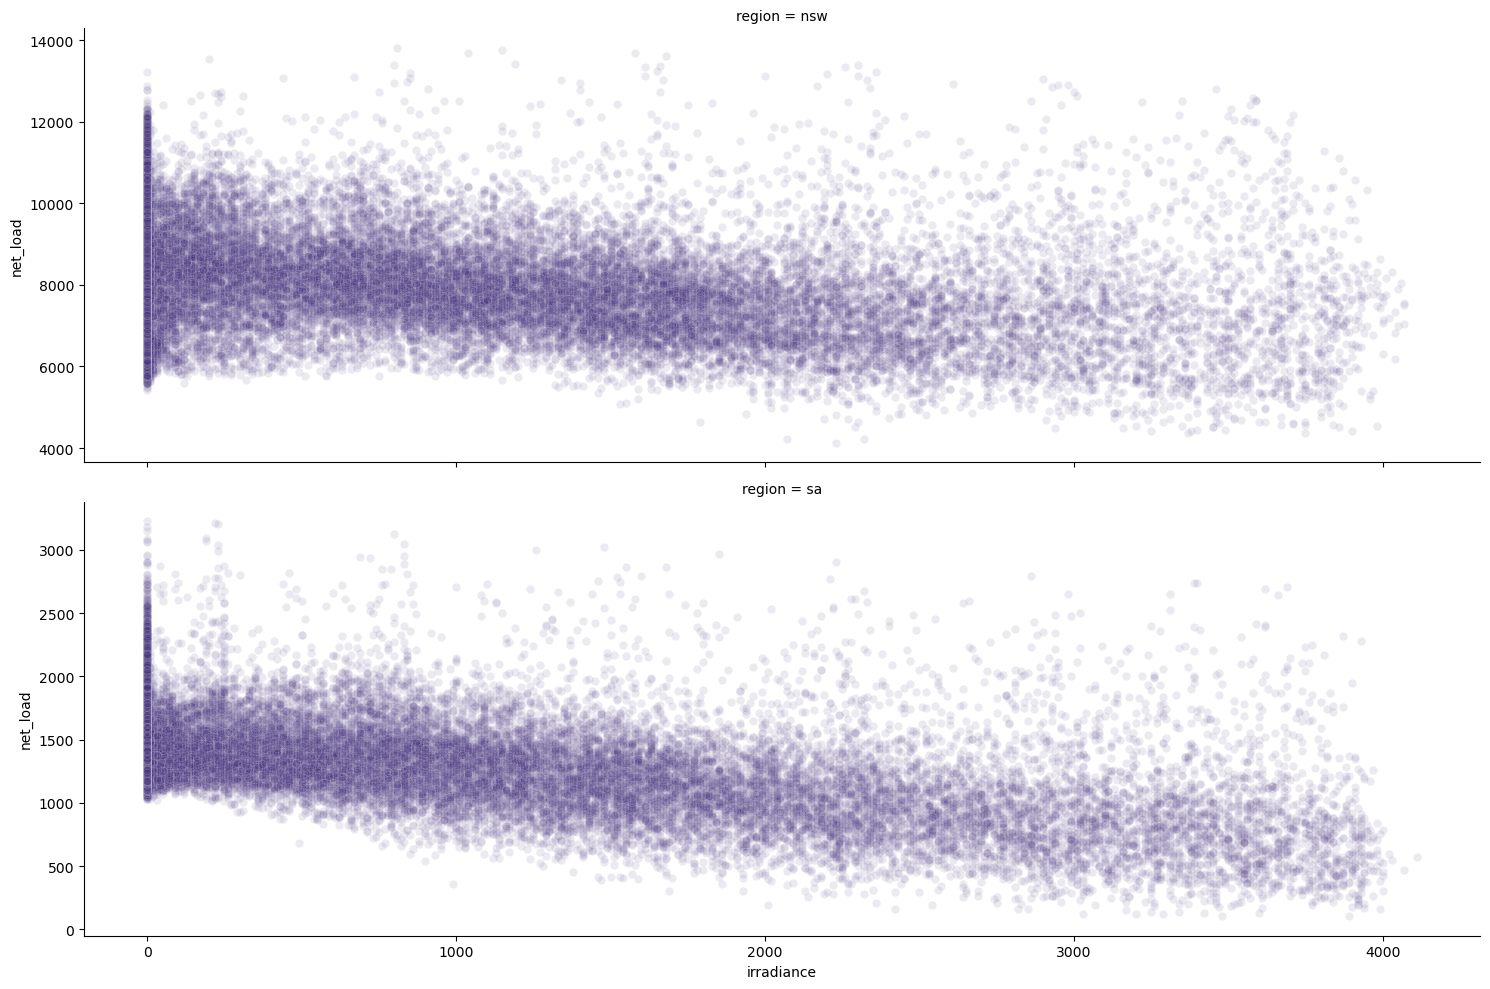

In [7]:
scatter(['radkjm2', 'radkjm2_syd'], 'irradiance', 0.1).savefig('../plots/pairs_radkjm.png')

32547    2021-11-21
32692    2021-11-27
Name: datetime, dtype: object


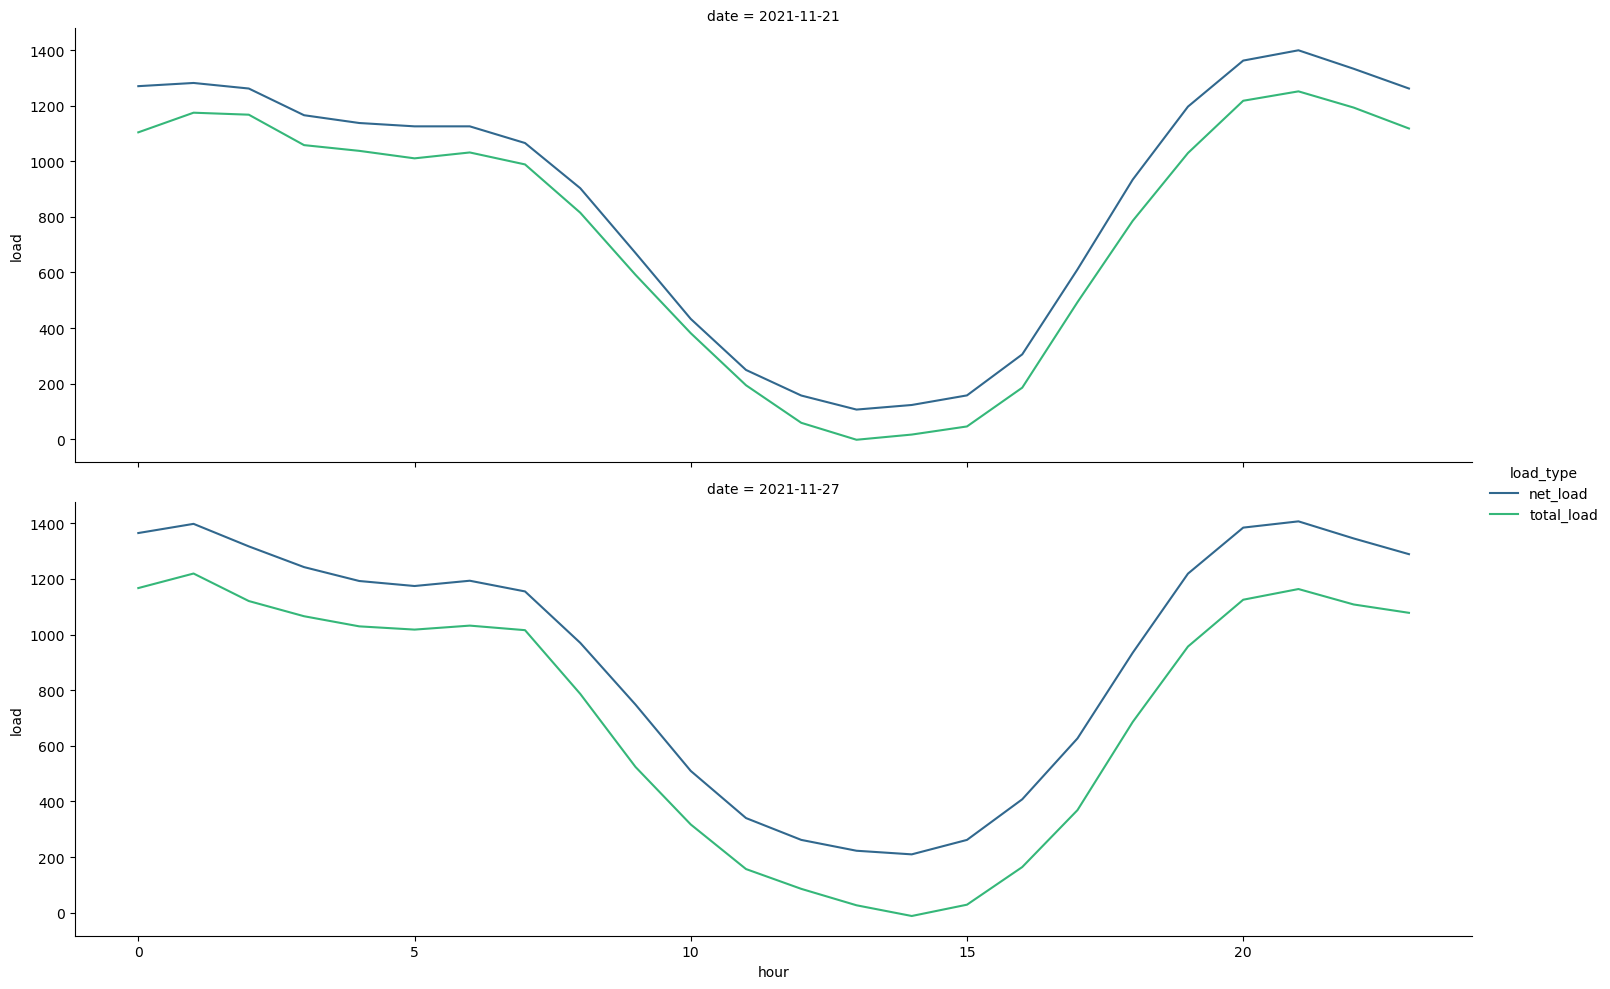

In [27]:
negative_load_days = df.loc[df.total_load < 0, 'datetime'].dt.date
print(negative_load_days)
negative_load_df = df[np.logical_and(df.datetime.dt.date.isin(negative_load_days), df.region=='sa')]
neg_load_melted = negative_load_df.melt(id_vars=['date', 'hour'], value_vars=['net_load', 'total_load'], value_name='load', var_name='load_type')
g = sns.relplot(neg_load_melted, x='hour', y='load', row='date', kind='line', hue='load_type', palette='viridis', aspect=3)
g.savefig('../plots/negative_load.png')